## Навигатор
* [1. Подключение необходимых библиотек и данных](#lib)
* [2. Загрузка данных в Data Frame](#load)
* [3. Приведение и оптимизация типов](#types)
* [4. EDA](#eda)
    * [4.1. Основные статистики](#eda_def)
    * [4.2. Исследование вещественных признаков](#eda_num_features)
    * [4.3. Исследование номинативных признаков](#eda_nom)
    * [4.4. Исследование целевой переменной](#eda_target)
* [5. Обработка выбросов и пропусков](#out_nan)
    * [5.1. Вещественные признаки](#out_nan_def)
    * [5.2. Номинативные признаки](#out_nan_mat)
* [6. Классы подготовки данных](#data_prepare)
* [7. Разбиение на train и test](#split)
* [8. Построение модели](#modeling)
* [9. Прогнозирование на тестовом датасете](#prediction)

## 1. Подключение библиотек и скриптов <a class='anchor' id='lib'>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 10})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### **Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

## 2. Загрузка данных в Data Frame <a class='anchor' id='load'>

### Описание файлов
- **train.csv** - тренировочные данные
- **test.csv** - тестовые данные
- **sampleSubmission.csv** - образец файла для отправки в правильном формате

### Описание датасета:

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
# Визуально знакомимся с тренировочными данными
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
# Визуально знакомимся с тестовыми данными
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


## **3. Приведение и оптимизация типов** <a class='anchor' id='types'>

In [9]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [10]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 4. EDA <a class='anchor' id='eda'>

### 4.1. Основные статистики <a class='anchor' id='eda_def'>

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [13]:
# Процентное количество пропущенных значений
train_df.isnull().mean() * 100

Id                0.00
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64

## Вывод по основным статистикам:
* Rooms, Square, LifeSquare, KitchenSquare, HouseFloor имеют аномально низкие значения близкие и/или равные нулю
* Заметны выбросы максимальных значений у таких признаков как Rooms, Square, LifeSquare, KitchenSquare, HouseYear
* Есть пропущенные значения у признаков LifeSquare, Healthcare_1


### **4.2 Исследование вещественных признаков** <a class='anchor' id='eda_num_features'>

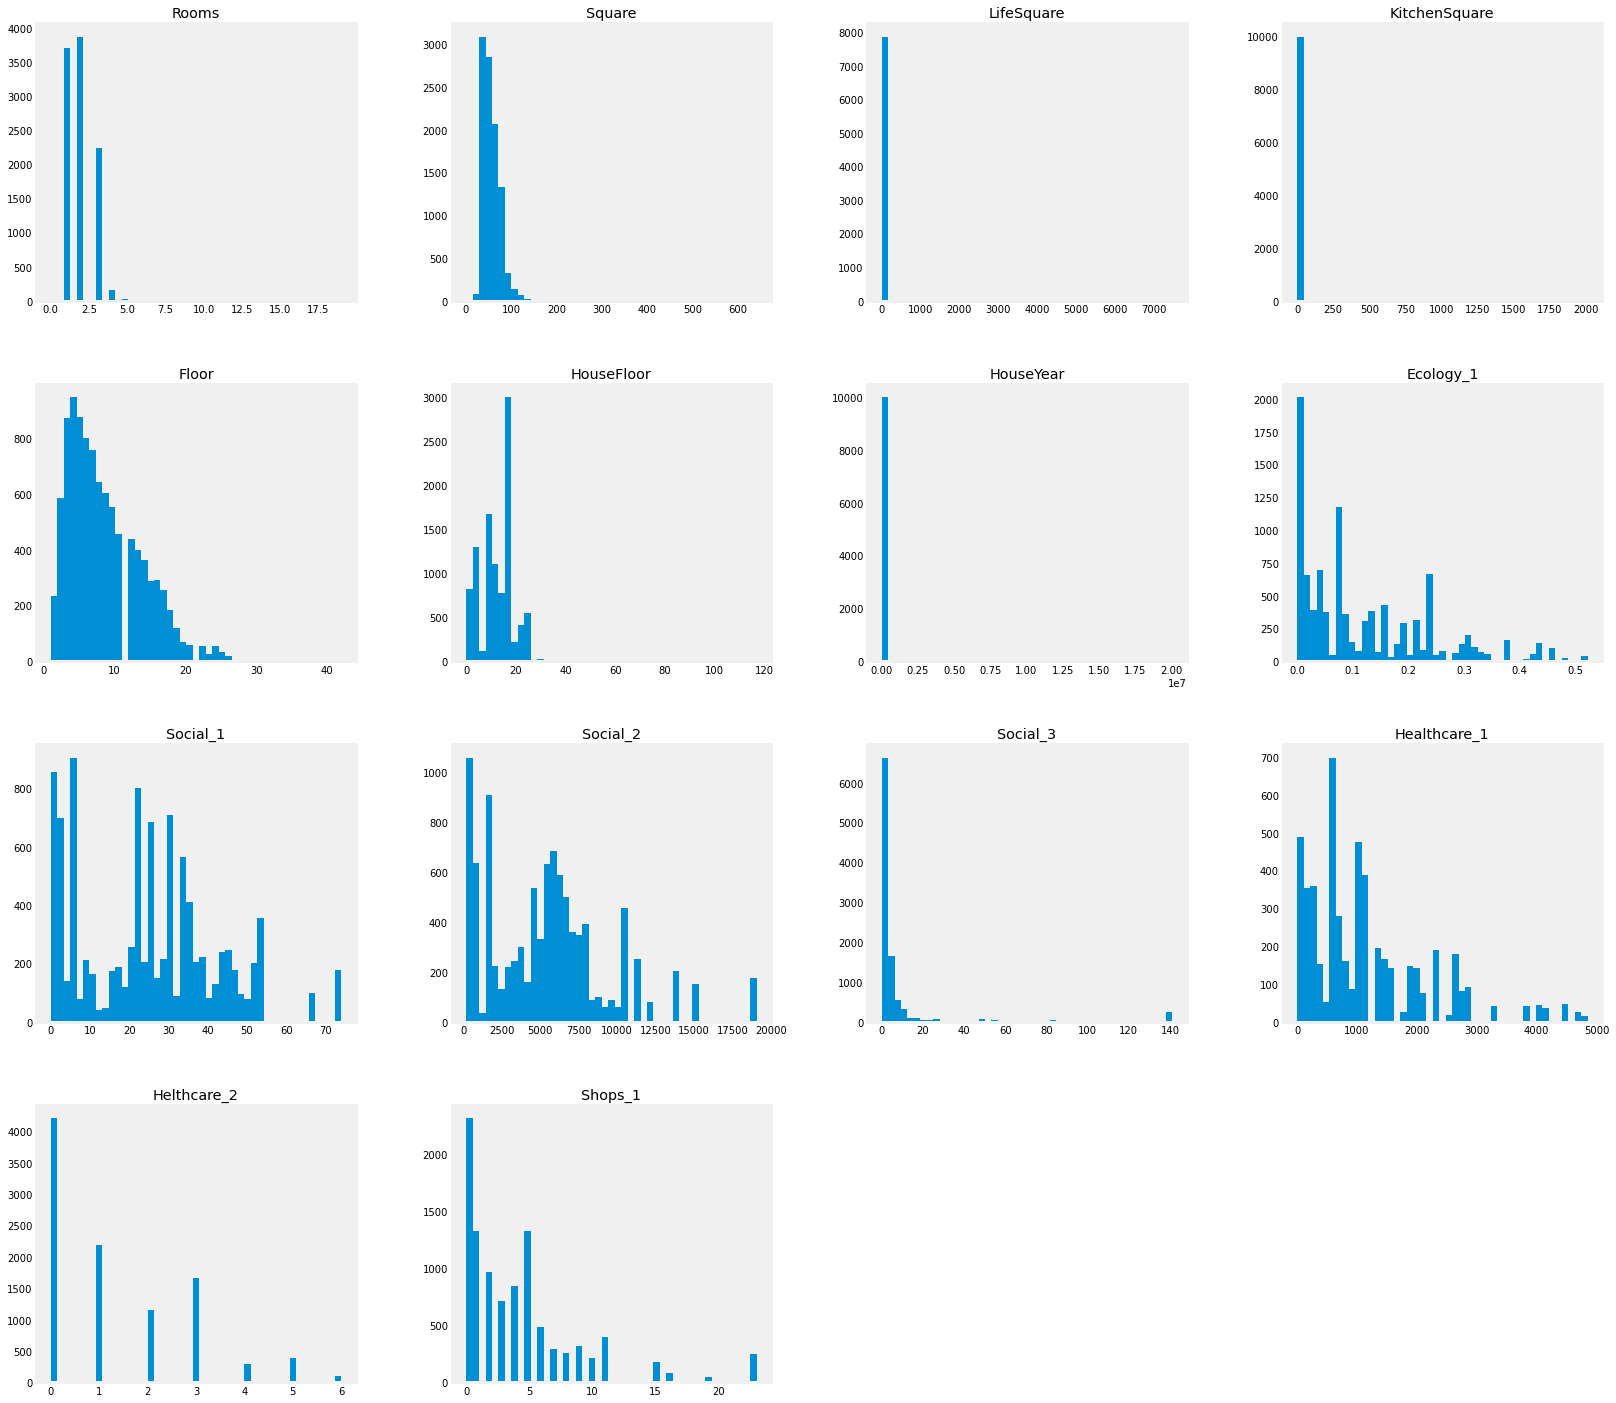

In [14]:
df_num_features = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'float32'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.hist(figsize=(25, 25), bins=45, grid=False);

### **4.3. Исследование номинативных признаков** <a class='anchor' id='eda_nom'>

In [15]:
df_nom_features = train_df.select_dtypes(include=['object', 'category'])

for feature in df_nom_features:
    print('Количество уникальных значений признака ' + feature + '\n')
    print(train_df[feature].value_counts())
    print()

Количество уникальных значений признака Id

1815     1
3579     1
6830     1
11038    1
1704     1
        ..
1570     1
12730    1
12492    1
1999     1
4386     1
Name: Id, Length: 10000, dtype: int64

Количество уникальных значений признака DistrictId

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
207      1
199      1
209      1
196      1
Name: DistrictId, Length: 205, dtype: int64

Количество уникальных значений признака Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64

Количество уникальных значений признака Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64

Количество уникальных значений признака Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64



### Выводы по номинативным признакам

#### DistrictId
Аномалий не наблюдается.
Вся территория делится на 205 районов,минимальное значение 0 может говоить о том, что индексация начинается с 0.

#### Ecology_2
Больше всего зданий относится к классу B

#### Ecology_3
Больше всего зданий относится к классу B

#### Shops_2
Типы магазинов поблизости. Больше всего магазинов типа B.

### 4.4. Исследование целевой переменной <a class='anchor' id='eda_target'>

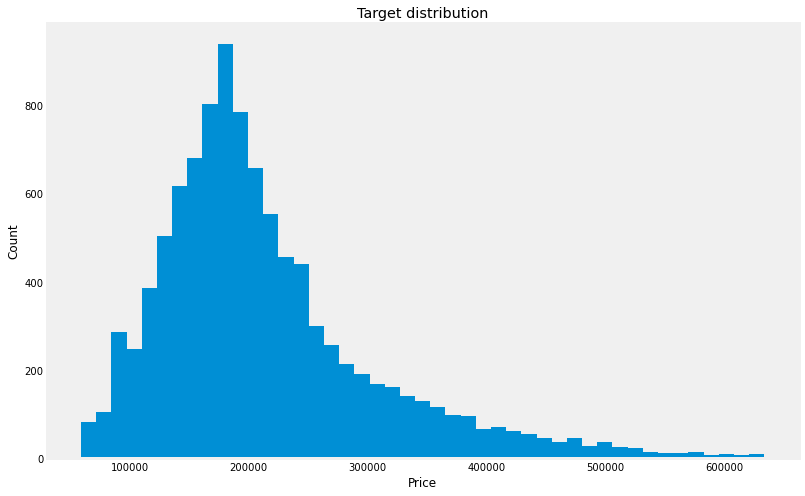

In [16]:
plt.figure(figsize = (12, 8))

train_df['Price'].hist(bins=45, grid=False)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

## 5. Обработка выбросов и пропусков <a class='anchor' id='out_nan'>

### 5.1. Вещественные признаки <a class='anchor' id='out_nan_def'>

### Rooms

In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [18]:
# Обработаем выбросы и нулевые значения комнат
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

### Square, LifeSquare, KitchenSquare

In [19]:
train_df.loc[train_df['Square'] < 5, 'Square'] = 7

In [20]:
condition = (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

### Floor, HouseFLoor

In [21]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [22]:
# Обрабатываем экземпляры у которых этаж квартиры выше этажности дома
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['HouseFloor'].median()

#train_df.loc[X['HouseFloor'] > 50, 'HouseFloor'] = train_df['HouseFloor'].median()

# Обрабатываем нулевой этаж дома
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

### HouseYear

In [23]:
from datetime import datetime
date_t=datetime.now().year

In [24]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [25]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011 

### 5.2. Номинативные признаки <a class='anchor' id='out_nan_mat'>

In [26]:
# Заменим буквенные значения на числовые
litera = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(litera)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(litera)
train_df['Shops_2'] = train_df['Shops_2'].replace(litera)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.718750
3,2352,1,1.0,40.409908,NaN,3.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.093750


## 6. Классы подготовки данных <a class='anchor' id='data_prepare'>

In [27]:
class DataPreprocessing:
        """Подготовка исходных данных"""

        def __init__(self):
            """Параметры класса"""
            self.medians=None
            self.kitchen_square_quantile = None
            self.binary_to_numbers = None


        def fit(self, X):
            """Сохранение статистик"""       
            self.medians = X.median()
            self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
            


        def transform(self, X):
            """Трансформация данных"""

            # Rooms
            X.loc[X['Rooms'] == 0, 'Rooms'] = 1
            X.loc[(train_df.Rooms >= 6), 'Rooms'] = X['Rooms'].median()
            
            # Square
            X.loc[X['Square'] < 5, 'Square'] = 7
            
            # Floor, HouseFLoor
            X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['HouseFloor']
            X.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = X['HouseFloor'].median()

            # Square
            X.loc[X['Square'] < 5, 'Square'] = 7

            # KitchenSquare
            condition = (X['KitchenSquare'] > X['KitchenSquare'].quantile(.975))

            X.loc[condition, 'KitchenSquare'] = X['KitchenSquare'].median()

            X.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 4

            # HouseYear
            X.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011
            
            # LifeSquare
            X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
            
            condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
            X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
            
            X.loc[(X['Social_3'] > 10), 'Social_3'] = self.medians['Social_3']
            
            # Healthcare_1
            if 'Healthcare_1' in X.columns:
                X.drop('Healthcare_1', axis=1, inplace=True)
            
            return X
            
class DataDummies():
    
    def __init__(self):
        self.binary_to_numbers = None
    
    
    def fit(self):
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        
    def transform(self, X):
        
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        return X
    
    
    def floor_to_cat(self, X):
        X['floor_cat'] = 0
        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 12), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 12) & (X['Floor'] <= 20), 'floor_cat'] = 4
        X.loc[X['Floor'] > 20, 'floor_cat'] = 5
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X
     
        
    def age_to_cat(self, X):
        X['age_cat'] = 0
        X.loc[(date_t - X['HouseYear']) <= 5, 'age_cat'] = 1
        X.loc[((date_t - X['HouseYear']) > 5) & ((date_t - X['HouseYear']) <= 10), 'age_cat'] = 2
        X.loc[((date_t - X['HouseYear']) > 10) & ((date_t - X['HouseYear']) <= 25), 'age_cat'] = 3
        X.loc[(date_t - X['HouseYear']) > 25, 'age_cat'] = 4
        X['age_cat'].fillna(-1, inplace=True)
        
        return X
    
    
    def ecology_to_cat(self, X):
        X['ecology_cat'] = 0
        X.loc[X['Ecology_1'] <= 0.1, 'ecology_cat'] = 1
        X.loc[(X['Ecology_1'] > 0.1) & (X['Ecology_1'] <= 0.2), 'ecology_cat'] = 2
        X.loc[(X['Ecology_1'] > 0.2) & (X['Ecology_1'] <= 0.3), 'ecology_cat'] = 3
        X.loc[(X['Ecology_1'] > 0.3) & (X['Ecology_1'] <= 0.4), 'ecology_cat'] = 4
        X.loc[X['Ecology_1'] > 0.4, 'ecology_cat'] = 5
        X['ecology_cat'].fillna(-1, inplace=True)

        return X

## 7. Разбиение на train и test <a class='anchor' id='split'>

In [28]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

# Создадим объекты классов и проинициализируем переменные
preprocessor = DataPreprocessing()
preprocessor.fit(test_df)

features_gen = DataDummies()
features_gen.fit()

# Подготовим данные
train_df = preprocessor.transform(train_df)
train_df = features_gen.transform(train_df)

test_df = preprocessor.transform(test_df)
test_df = features_gen.transform(test_df)

# Отделим целевую переменную
X = train_df.drop('Price', axis=1)
y = train_df['Price']

# Создадим тренировочные и валидацонные наборы
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# Посмотрим на размерности и пропуски в данных
print(X_train.shape, X_valid.shape, test_df.shape)
print(X_train.isna().sum().sum(), 
      X_valid.isna().sum().sum(),
      test_df.isna().sum().sum())

(6700, 19) (3300, 19) (5000, 19)
0 0 0


## 8. Построение модели <a class='anchor' id='modeling'>

### Обучение модели

In [29]:
gbr = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     random_state=42,
                                     min_samples_leaf=35,
                                     n_estimators=140)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=35,
                          n_estimators=140, random_state=42)

### Оценка модели

Train R2:	0.845
Test R2:	0.748


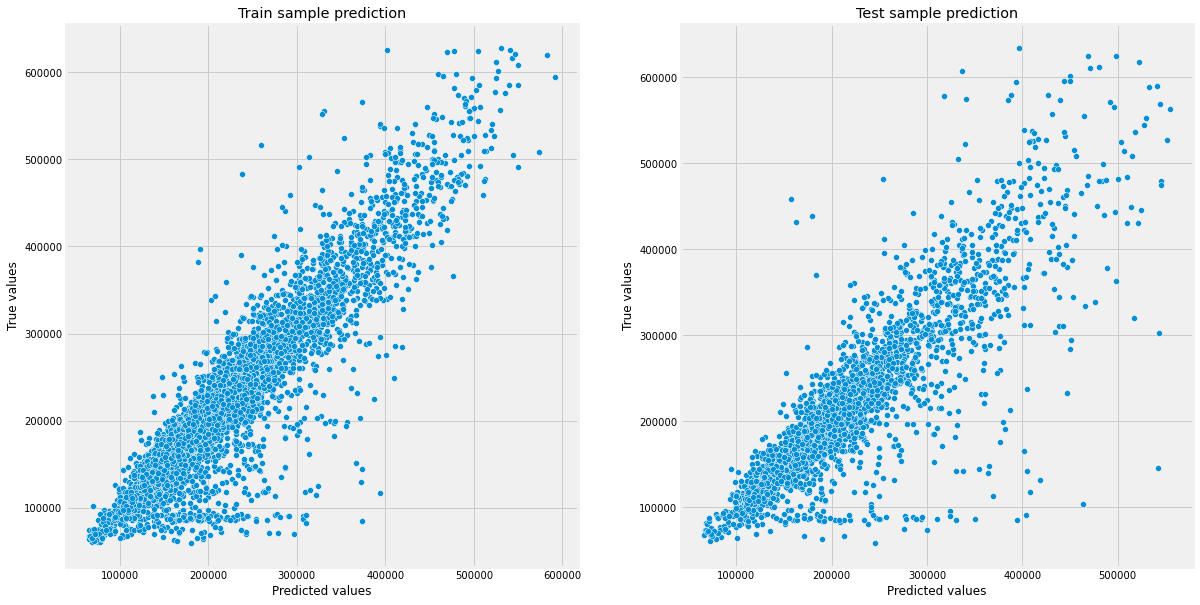

In [30]:
y_train_preds = gbr.predict(X_train)
y_test_preds = gbr.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [31]:
cv_score = cross_val_score(gbr, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.70867093, 0.69840591, 0.71657978])

In [32]:
feature_importances = pd.DataFrame(zip(X_train.columns, gbr.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.422459
13,Social_2,0.128286
12,Social_1,0.086918
2,Rooms,0.076983
1,DistrictId,0.066766
9,Ecology_1,0.049116
14,Social_3,0.045202
8,HouseYear,0.033075
4,LifeSquare,0.019079
5,KitchenSquare,0.016485


## 9. Прогнозирование на тестовом датасете <a class='anchor' id='prediction'>

In [33]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [34]:
predictions = gbr.predict(test_df)
predictions

NameError: name 'stack' is not defined

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('gbr_submit.csv', index=False)